# Time Series Project

#### Meng Lin, Hannah Lyon, Kyrill Rekun, Qingyi Sun

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
df = pd.read_csv('zillow-california.csv', squeeze=True)
df.columns = ['Date','Median_Sold_Price','Median_Mortgage','Unemployment','Median_Rental_Price']
df = df.reset_index()
df.drop(['Date'], axis=1, inplace=True)
df.head()

,index,Median_Sold_Price,Median_Mortgage,Unemployment,Median_Rental_Price
0,0,326752.55,5.02,7.9,NaN
1,1,329501.50,4.94,7.8,NaN
2,2,340125.45,4.74,7.8,NaN
3,3,355329.50,5.16,7.5,NaN
4,4,367818.15,5.64,7.3,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 5 columns):
index                  164 non-null int64
Median_Sold_Price      144 non-null float64
Median_Mortgage        164 non-null float64
Unemployment           164 non-null float64
Median_Rental_Price    92 non-null float64
dtypes: float64(4), int64(1)
memory usage: 6.5 KB


In [4]:
x = df['Median_Sold_Price'].loc[(df['Median_Sold_Price'].notna())].values

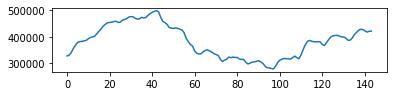

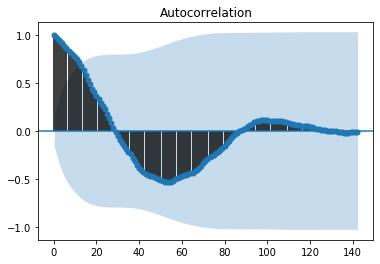

/Users/hannahlyon/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


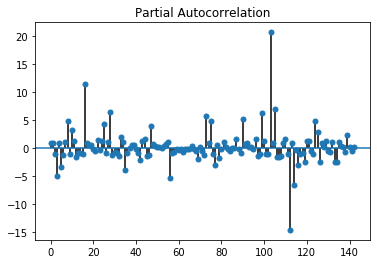

In [5]:
# draw plots
plt.subplot(3,1,1)
plt.plot(x) 
plt.show()
plot_acf(x, lags = 142) 
plt.show()
plot_pacf(x, lags = 142) 
plt.show()

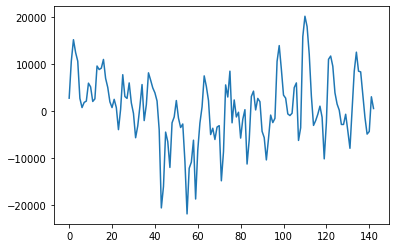

In [6]:
# try one time differencing
li_x = list(x)
d1 = list()
for i in range(1, len(li_x)):
    value = li_x[i] - li_x[i - 1]
    d1.append(float(value))
    
plt.plot(d1) 


In [7]:
# ADF TEST for d = 1

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(d1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


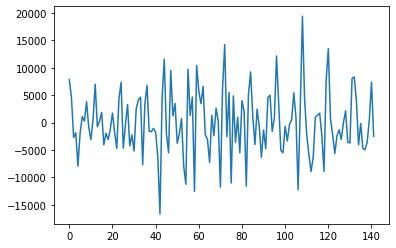

In [8]:
# two time differencing

d2 = list()
for i in range(1, len(d1)):
    value = d1[i] - d1[i - 1]
    d2.append(value)

plt.plot(d2)

In [9]:
# ADF for d = 2
adf_test(d2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


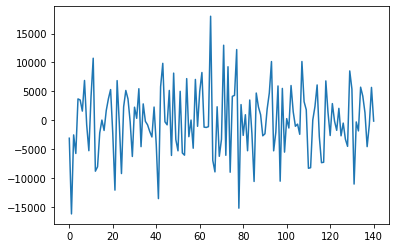

In [10]:
# differencing for seasonality
d3 = list()
for i in range(1, len(d2)):
    value = d2[i] - d2[i - 24]
    d3.append(value)

plt.plot(d3)

In [11]:
train_size = int(len(x) * 0.75)
train, test = df[0:train_size], df[train_size:]

### Fit Univariate Model

In [12]:
# fit univariate model
model = pm.auto_arima(x, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=24,
                           start_P=0, seasonal=True,
                           d=2, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 24); AIC=2369.727, BIC=2383.580, Fit time=6.123 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 24); AIC=2380.606, BIC=2386.147, Fit time=0.127 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 24); AIC=2384.332, BIC=2395.415, Fit time=0.596 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 24); AIC=2384.736, BIC=2395.819, Fit time=1.209 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 24); AIC=2370.728, BIC=2387.352, Fit time=2.898 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 24); AIC=2367.614, BIC=2378.697, Fit time=0.434 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 24); AIC=2382.738, BIC=2391.050, Fit time=0.074 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 1, 0, 24); AIC=2377.435, BIC=2391.288, Fit time=0.334 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 24); AIC=2382.333, BIC=2390.645, Fit time=0.061 seconds
Fit ARIMA: order=(1, 2, 2) s

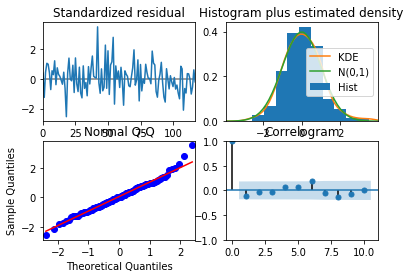

In [13]:
model.plot_diagnostics()
plt.show()

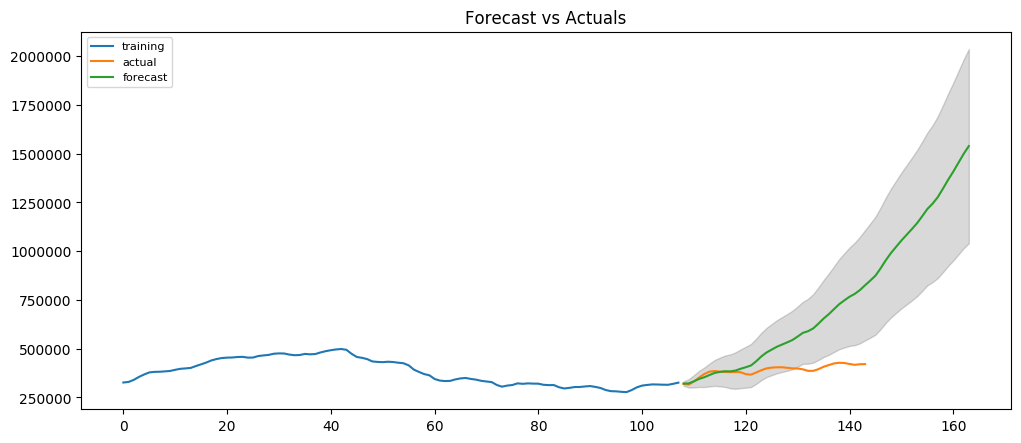

In [14]:
fitted = model.fit(train['Median_Sold_Price'])
fc, conf = fitted.predict(len(test),return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Median_Sold_Price'], label='training')
plt.plot(test['Median_Sold_Price'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
n_periods = len(test)
model.predict(n_periods=n_periods)

array([ 321239.41093016,  322227.3941347 ,  332933.27154682,
        345168.481307  ,  353736.7796242 ,  365053.4562905 ,
        375942.2966409 ,  380791.57439798,  384540.64464113,
        383783.3188261 ,  387816.60545761,  397084.9300959 ,
        404989.63227549,  414028.64102721,  435451.56559597,
        460457.06045768,  480645.73825763,  495567.11365741,
        510071.06711721,  521457.52153609,  532726.42718539,
        544727.75199105,  562411.47526591,  581327.58366712,
        589715.47951896,  604084.31861505,  628403.41930849,
        654484.21743073,  677130.4677014 ,  702757.45895204,
        728188.97589806,  747813.29186245,  766569.76166688,
        781052.19660086,  800557.60506188,  825530.41254105,
        849371.95852826,  874580.17202559,  912404.66225939,
        954044.08369361,  991099.04896581, 1023119.07273261,
       1054954.03545098, 1083903.86001792, 1112968.49670342,
       1142997.91343258, 1178942.08951765, 1216351.01161546,
       1243464.08205004,

In [16]:
mse = ((fc_series - test['Median_Sold_Price']) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

186732.74


In [17]:
model = ExponentialSmoothing(train['Median_Sold_Price'], trend="add", seasonal="add", seasonal_periods=24,damped=True)
model2 = ExponentialSmoothing(train['Median_Sold_Price'], trend="add", seasonal="mul", seasonal_periods=24, damped=True)
fit = model.fit()
pred = fit.forecast(len(test))
fit2 = model2.fit()
pred2 = fit2.forecast(len(test))

/Users/hannahlyon/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/hannahlyon/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


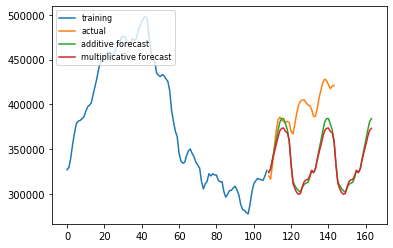

In [18]:
plt.plot(train['Median_Sold_Price'], label='training')
plt.plot(test['Median_Sold_Price'], label='actual')
plt.plot(pred, label='additive forecast')
plt.plot(pred2, label='multiplicative forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
rmse1 = np.sqrt(np.mean(np.square(test['Median_Sold_Price'] - pred.values)))
rmse2 = np.sqrt(np.mean(np.square(test['Median_Sold_Price'] - pred2.values)))
print(rmse1)
print(rmse2)

56513.312980166054
58244.407353945295


### Test multivariate case

In [20]:
unemployment = df['Unemployment'].values
exog_train = unemployment[:train_size, None]
exog_test = unemployment[train_size:,None]

In [21]:
modelx = SARIMAX(train['Median_Sold_Price'], order=(1,2,1),exog=exog_train)
fitx=modelx.fit()
print(fitx.summary())

                           Statespace Model Results                           
Dep. Variable:      Median_Sold_Price   No. Observations:                  108
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1061.204
Date:                Tue, 26 Nov 2019   AIC                           2130.409
Time:                        15:12:46   BIC                           2141.063
Sample:                             0   HQIC                          2134.727
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -434.2420    637.973     -0.681      0.496   -1684.646     816.162
ar.L1          0.8277      0.092      8.951      0.000       0.646       1.009
ma.L1         -0.9284      0.078    -11.949      0.0

In [30]:
fc = fitx.predict(start=train_size, end=train_size + len(exog_test) - 1, exog=exog_test)

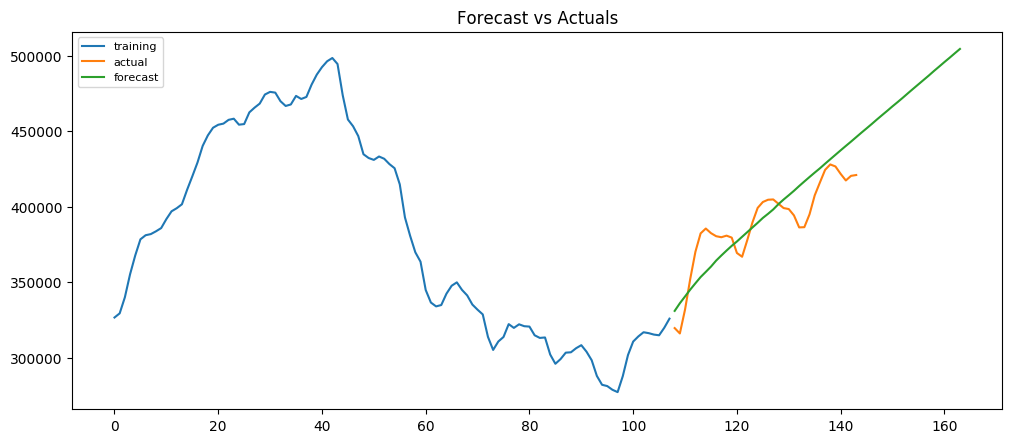

In [31]:
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Median_Sold_Price'], label='training')
plt.plot(test['Median_Sold_Price'], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [32]:
mse = ((fc_series - test['Median_Sold_Price']) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

16105.74


In [24]:
model = pm.auto_arima(train['Median_Sold_Price'], exogenous=exog_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, 
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2184.809, BIC=2198.173, Fit time=0.170 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2204.010, BIC=2212.029, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2223.875, BIC=2234.566, Fit time=0.019 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2212.118, BIC=2222.809, Fit time=0.031 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2194.347, BIC=2210.384, Fit time=0.149 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2193.341, BIC=2209.378, Fit time=0.123 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=2194.312, BIC=2213.022, Fit time=0.094 seconds
Total fit time: 0.600 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(1, 1, 1)   Log Likelihood         

In [35]:
series = df[['Unemployment', 'Median_Mortgage']]
train = series[:int(0.75*(len(series)))]
test = series[int(0.75*(len(series))):]
train.head()

,Unemployment,Median_Mortgage
0,7.9,5.02
1,7.8,4.94
2,7.8,4.74
3,7.5,5.16
4,7.3,5.64
